![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/legal-nlp/07.0.Understand_Entities_in_Context.ipynb)

# Understanding Legal Entities In Context
Assertion Status, or *Understanding Legal Entities in Context*, is an NLP task in carge of analyzing NER entities, extracted with:
- NER models;
- ContextualParser;

and their surroundings (usually a sentence, but it could take bigger spans too) to *assert* different conditions / status on the entities, as:
- If an entity is negated in the context;
- If the context talks about past, present, or future;
- If the entity is said to be hypothetical / possible, or certaing;
- etc.

The exposed above are just some examples, since the applications of Assertion DL models can be expanded to whatever to many other scenarios where you need to:
- Disambiguate entities from the context.
- Subclassify or specify an entity depending on context:

You can even carry out `Sentiment Analysis` at entity-based with Assertion Status, where several entities may have specific sentiments associated to them.


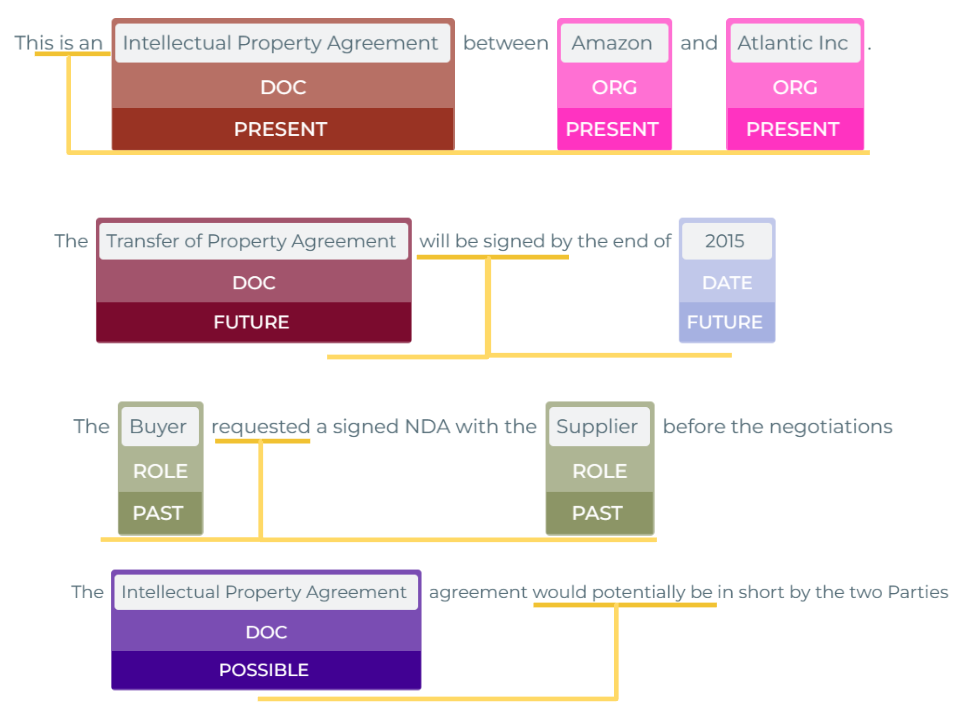

Let's see which pretrained models we have and how to train custom ones!

# Installation

In [ ]:
! pip install -q johnsnowlabs

## Automatic Installation
Using my.johnsnowlabs.com SSO

In [ ]:
from johnsnowlabs import nlp, legal

# nlp.install(force_browser=True)

## Manual downloading
If you are not registered in my.johnsnowlabs.com, you received a license via e-email or you are using Safari, you may need to do a manual update of the license.

- Go to my.johnsnowlabs.com
- Download your license
- Upload it using the following command

In [ ]:
from google.colab import files
print('Please Upload your John Snow Labs License using the button below')
license_keys = files.upload()

- Install it

In [ ]:
nlp.install()

# Starting

In [ ]:
spark = nlp.start()

In [ ]:
from pyspark.sql import DataFrame
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pyspark.sql as SQL
from pyspark import keyword_only

## Understanding time from context

### Small examples: Detecting time of a Document Signing
Let's start with a small examples: analyzing whether a DOC (for example, an agreement) is mentioned to be signed in the `past`, `present` or `future`.

For that, we need:
- An NER model. We wiroberta_embeddings_legal_roberta_basell use `legner_contract_doc_parties` which uses `bert_embeddings_sec_bert_base` embeddings to extract `DOC`,  `PARTY`, `EFFDATE` entities, among others;
- An Assertion Model which detects time. We will use `legassertion_time`.

In [ ]:
from sparknlp_jsl.legal.token_classification.ner.legal_ner import LegalNerApproach
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetector()\
    .setInputCols(["document"])\
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = nlp.RoBertaEmbeddings.pretrained("roberta_embeddings_legal_roberta_base", "en") \
    .setInputCols("sentence", "token") \
    .setOutputCol("embeddings")\

ner_model = legal.NerModel.pretrained('legner_contract_doc_parties', 'en', 'legal/models')\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = legal.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner"])\
    .setOutputCol("ner_chunk")\
    .setWhiteList(["DOC", "EFFDATE", "PARTY"]) # We will check time only on these

ner_model_roles = legal.NerModel.pretrained('legner_roles', 'en', 'legal/models')\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner_roles")

ner_converter_roles = legal.NerConverterInternal()\
    .setInputCols(["sentence", "token", "ner_roles"])\
    .setOutputCol("ner_chunk_roles")

chunk_merger = legal.ChunkMergeApproach()\
    .setInputCols('ner_chunk', "ner_chunk_roles")\
    .setOutputCol('merged_ner_chunk')\
    .setOrderingFeatures(["ChunkLength"])\
    .setSelectionStrategy("DiverseLonger")

assertion = legal.AssertionDLModel.pretrained("legassertion_time_md", "en", "legal/models")\
    .setInputCols(["sentence", "merged_ner_chunk", "embeddings"]) \
    .setOutputCol("assertion")

nlpPipeline = nlp.Pipeline(stages=[
            document_assembler, 
            sentence_detector,
            tokenizer,
            embeddings,
            ner_model,
            ner_converter,
            ner_model_roles,
            ner_converter_roles,
            chunk_merger,
            assertion
            ])

empty_data = spark.createDataFrame([[""]]).toDF("text")     

roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[OK!]
legner_contract_doc_parties download started this may take some time.
[OK!]
legner_roles download started this may take some time.
[OK!]
legassertion_time_md download started this may take some time.
[OK!]


## LightPipelines inference
We will use `LightPipelines`instead of `fit/transform` to speed up the process, since we only will be checking a few sentences

In [ ]:
model = nlpPipeline.fit(empty_data)

light_model = nlp.LightPipeline(model)

### Example sentences extracted from legal agreements (CUAD dataset)

In [ ]:
sample_texts = ["""The Intellectual Property Agreement may be signed by the two Parties""",
               """The Sponsorship Agreement will be signed""",
               """This is a Intellectual Property Agreement between Amazon.com Inc and Atlantic Inc.""",
               """This Sponsorship Agreement was entered into as of December 18, 1998, by and between Ford Motor Media, a division of J. Walter Thompson with offices at 300 Renaissance Center, Detroit, Michigan 48243 and iVillage Inc., with offices at 170 Fifth Avenue, New York, New York 10010.""",
               """2006 SENIOR NOTES shall mean the Company's 7 ?% senior notes""",
               """2006 ACCOUNTS RECEIVABLE FACILITY DOCUMENTS means all documentation entered into by the Company and its Subsidiaries""",
               """ADMINISTRATIVE AGENT'S LETTER shall have the meaning assigned to that term in Section 9.15.""",
               """AFFILIATE as to any Person shall mean any other Person (i) which, directly or indirectly controls""",
               """The Borrowers may request the Lenders to make Revolving Credit Loans""",
               """Each Swing Loan Request shall be irrevocable and shall specify the proposed Borrowing Date AFFILIATE""",
               """Which was launched on 19 November 2007.""",
               """The Administrative Agent will determine the Dollar Equivalent amount""",
               """This is an Intellectual Property Agreement between Amazon.com and Atlantic INC""",
               """The Intellectual Property Agreement may be signed by the two Parties""",
               """This Sponsorship Agreement was entered into as of December 18""",
               """WHEREAS, the Borrowers have requested the Lenders to provide a revolving credit facility to the Borrowers in an aggregate principal amount not to""",
               """(ii) Opinion of Counsel. The English Borrowers shall deliver to the Administrative Agent an Opinion of its English counsel in a form acceptable""",
               """This Agreement may be executed by different parties hereto""",
               """IN WITNESS WHEREOF, the parties hereto, by their officers there unto duly authorized, have executed this Agreement"""
]
     

### We extract with LightPipelines

In [ ]:
import pandas as pd

chunks=[]
entities=[]
status=[]

for i in range(len(sample_texts)):
  light_result = light_model.fullAnnotate(sample_texts[i])[0]

  for n,m in zip(light_result['merged_ner_chunk'],light_result['assertion']):
    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

In [ ]:
df

,chunks,entities,assertion
0,Intellectual Property Agreement,DOC,POSSIBLE
1,Parties,ROLE,POSSIBLE
2,Sponsorship Agreement,DOC,FUTURE
3,Intellectual Property Agreement,DOC,PRESENT
4,Amazon.com Inc,PARTY,PRESENT
5,Atlantic Inc,PARTY,PRESENT
6,Sponsorship,DOC,PAST
7,"December 18, 1998",EFFDATE,PAST
8,"Ford Motor Media,",PARTY,PAST
9,iVillage,PARTY,PAST


### Visualization of Assertion Status

In [ ]:
for i in range(len(sample_texts)):
    
    light_result = light_model.fullAnnotate(sample_texts[i])[0]
    
    vis = nlp.viz.AssertionVisualizer()

    vis.display(light_result, 'merged_ner_chunk', 'assertion')

# Writing a Generic Assertion + NER Function
You can generalize and retrieve components or full pipelines using functions.

This is an example of how you can achieve that.

In [ ]:
def get_base_pipeline(embeddings, embeddings_annotator):

    documentAssembler = nlp.DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")

    sentenceDetector = nlp.SentenceDetector()\
        .setInputCols(["document"])\
        .setOutputCol("sentence")

    tokenizer = nlp.Tokenizer()\
        .setInputCols(["sentence"])\
        .setOutputCol("token")

    embeddings = embeddings_annotator.pretrained(embeddings, "en") \
        .setInputCols(["sentence", "token"]) \
        .setOutputCol("embeddings")

    base_pipeline = nlp.Pipeline(stages=[
                        document_assembler,
                        sentence_detector,
                        tokenizer,
                        embeddings])

    return base_pipeline


def get_assertion (embeddings, ner_model, assertion_model,
                   embeddings_annotator=nlp.RoBertaEmbeddings):

    ner = legal.NerModel.pretrained(ner_model, "en", "legal/models")\
        .setInputCols(["sentence", "token", "embeddings"]) \
        .setOutputCol("ner")

    ner_converter = nlp.NerConverter() \
        .setInputCols(["sentence", "token", "ner"]) \
        .setOutputCol("ner_chunk")
    
    assertion = legal.AssertionDLModel.pretrained(assertion_model, "en", "legal/models")\
        .setInputCols(["sentence", "ner_chunk", "embeddings"])\
        .setOutputCol("assertion")
      
    base_model = get_base_pipeline(embeddings, embeddings_annotator)

    nlpPipeline = nlp.Pipeline(stages=[
        base_model,
        ner,
        ner_converter,
        assertion])

    empty_data = spark.createDataFrame([[""]]).toDF("text")

    model = nlpPipeline.fit(empty_data)
    
    light_model = nlp.LightPipeline(model)
    
    return light_model
    

Let's use the credit agreement document...

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/credit_agreement.txt

In [ ]:
with open('credit_agreement.txt', 'r') as f:
  credit_agreement = f.read()

In [ ]:
credit_agreement[:300]

'\n\n                                                                    Exhibit 10.1\n\n                                                                  EXECUTION COPY\n\n                    $225,000,000.00 REVOLVING CREDIT FACILITY\n\n                                CREDIT AGREEMENT\n\n                     '

Let's normalize the spacing...

In [ ]:
import re
credit_agreement = re.sub(r'\s+',' ', credit_agreement[:300])
credit_agreement

' Exhibit 10.1 EXECUTION COPY $225,000,000.00 REVOLVING CREDIT FACILITY CREDIT AGREEMENT '

### Quick inference with LightPipeline

In [ ]:
embeddings = "roberta_embeddings_legal_roberta_base"

embeddings_annotator = nlp.RoBertaEmbeddings

ner_model = "legner_roles"

assertion_model = "legassertion_time_md"

light_result = get_assertion(embeddings, ner_model, assertion_model, embeddings_annotator).fullAnnotate(credit_agreement)[0]

chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

legner_roles download started this may take some time.
[OK!]
legassertion_time_md download started this may take some time.
[OK!]
roberta_embeddings_legal_roberta_base download started this may take some time.
Approximate size to download 447.2 MB
[OK!]


In [ ]:
df

,chunks,entities,assertion


### Visualization of Assertion Status

In [ ]:
vis = nlp.viz.AssertionVisualizer()

vis.display(light_result, 'ner_chunk', 'assertion')

# Identify `Negation` in context
This model uses Assertion Status to identify if an **ORG** or **PRODUCT** is followed by a `negation particle` in the context.

Again, this is a model uses the context around `PRODUCT` or `ORGANIZATION` to further subclassify them.

For that, we need:
- An NER model. We will use `legner_orgs_prods_alias` which uses `bert_embeddings_sec_bert_base` embeddings to extract `PERSON`, `PRODUCT` and `ALIAS` entities;
- An Assertion Model which detects negation. We will use `legassertion_negation` which retrieves if an entity is present in a `positive` or `negative` context.

**Please keep in mind that you can use this model also in other entities, but the performance may be affected**


### Quick inference with LightPipeline

In [ ]:
sample_text = """EDH combines our Cloudera Data Warehouse, Cloudera Operational DB, and Cloudera Data Science with our SDX technology."""

embeddings = "bert_embeddings_sec_bert_base"

embeddings_annotator = nlp.BertEmbeddings

ner_model = "legner_orgs_prods_alias"

assertion_model = "legassertion_negation"

light_result = get_assertion(embeddings, ner_model, assertion_model, embeddings_annotator).fullAnnotate(sample_text)[0]

legner_orgs_prods_alias download started this may take some time.
[OK!]
legassertion_negation download started this may take some time.
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]


In [ ]:
chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

In [ ]:
df

,chunks,entities,assertion
0,EDH,ORG,positive
1,Cloudera Data Warehouse,PRODUCT,positive
2,Cloudera Operational DB,PRODUCT,positive
3,Cloudera Data Science,PRODUCT,positive
4,SDX,PRODUCT,positive


In [ ]:
sample_text = """Whatsapp did not borrow funds from Meta for its capital needs. Synapsis INC will not be considered as eligible for X Engineering, Inc. supplier financing program."""

In [ ]:
light_result = get_assertion(embeddings, ner_model, assertion_model, embeddings_annotator).fullAnnotate(sample_text)[0]

legner_orgs_prods_alias download started this may take some time.
[OK!]
legassertion_negation download started this may take some time.
[OK!]
bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]


In [ ]:
chunks=[]
entities=[]
status=[]

for n,m in zip(light_result['ner_chunk'],light_result['assertion']):

    chunks.append(n.result)
    entities.append(n.metadata['entity']) 
    status.append(m.result)

df = pd.DataFrame({'chunks':chunks, 'entities':entities, 'assertion':status})

In [ ]:
df

,chunks,entities,assertion
0,Whatsapp,ORG,negative
1,Meta,ORG,positive
2,Synapsis INC,ORG,negative
3,"X Engineering, Inc",ORG,positive


### Visualization of Assertion Status

In [ ]:
vis = nlp.viz.AssertionVisualizer()

vis.display(light_result, 'ner_chunk', 'assertion')

# Training Assertion Status
Let's have a look at what takes to train your custom AssertionDL model for `negation`.

- First, make sure you have an **NER model** which retrieves those entities for you. In our case, we will use `finner_orgs_prods_alias` with requires `bert_embeddings_sec_bert_base` embeddings
- Second, check the embeddings the NER model is using and *reuse* them for the Assertion Model, so that you don't calculate embeddings twice.


### Dataframe Format
This is the format you need for training your data

In [ ]:
!wget https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/legal-nlp/data/assertion_df.csv

In [ ]:
df = pd.read_csv('assertion_df.csv')
df

,text,target,label,start,end
0,CEC ENTERTAINMENT INC is not purchasing GEO GR...,CEC ENTERTAINMENT INC,negative,0,2
1,CEC ENTERTAINMENT INC is not purchasing GEO GR...,GEO GROUP INC,positive,6,8
2,BRAVE ASSET MANAGEMENT INC is paying Mondelez ...,"Mondelez International , Inc .",positive,6,10
3,BRAVE ASSET MANAGEMENT INC is paying Mondelez ...,BRAVE ASSET MANAGEMENT INC,positive,0,3
4,Compound Natural Foods Inc . is not investing ...,Compound Natural Foods Inc .,negative,0,4
...,...,...,...,...,...
93,"Cboe EDGA Exchange , Inc . is not providing Bl...","BlueStar Financial Group , Inc .",positive,9,14
94,VSOURCE INC is hiring URSTADT BIDDLE PROPERTIE...,URSTADT BIDDLE PROPERTIES INC,positive,4,7
95,VSOURCE INC is hiring URSTADT BIDDLE PROPERTIE...,VSOURCE INC,positive,0,1
96,Emergent BioSolutions Inc . is not providing C...,Emergent BioSolutions Inc .,negative,0,3


- `text`: your text examples;
- `target`: your NER chunk, extracted using `finner_orgs_prods_alias` in our case;
- `label`: the assertion label. In our example, we have two labels: `positive` and `negative`.
- `start`: the first token number of the chunk. You can get this information from the `begin` column in your NER model metadata.
- `end`: the last token number of the chunk. You can get this information from the `end` column in your NER model metadata.

### Text Embeddings
Calculated using the `bert_embeddings_sec_bert_base` embeddings on your `text` column

In [ ]:
document = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

# Feel free to use a SentenceDetector if you have texts consisting of more than one sentence

token = nlp.Tokenizer()\
    .setInputCols(['document'])\
    .setOutputCol('token')

chunk = nlp.Doc2Chunk()\
    .setInputCols("document")\
    .setOutputCol("chunk")\
    .setChunkCol("target")\
    .setStartCol("start")\
    .setStartColByTokenIndex(True)\
    .setFailOnMissing(False)\
    .setLowerCase(False)

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
    .setInputCols(["document", "token"]) \
    .setOutputCol("embeddings")

embeddings_pipeline = nlp.Pipeline(stages=[document, token, chunk, embeddings])

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]


### Dataframe creation: training and test splits

In [ ]:
assertion_sdf = spark.createDataFrame(df)
assertion_sdf.show()

+--------------------+--------------------+--------+-----+---+
|                text|              target|   label|start|end|
+--------------------+--------------------+--------+-----+---+
|CEC ENTERTAINMENT...|CEC ENTERTAINMENT...|negative|    0|  2|
|CEC ENTERTAINMENT...|       GEO GROUP INC|positive|    6|  8|
|BRAVE ASSET MANAG...|Mondelez Internat...|positive|    6| 10|
|BRAVE ASSET MANAG...|BRAVE ASSET MANAG...|positive|    0|  3|
|Compound Natural ...|Compound Natural ...|negative|    0|  4|
|Compound Natural ...|AMERICAN ELECTRIC...|positive|    9| 13|
|Marijuana Co of A...|PVM International...|positive|   10| 14|
|Marijuana Co of A...|Marijuana Co of A...|positive|    0|  6|
|NORTEK INC is not...|          NORTEK INC|negative|    0|  1|
|NORTEK INC is not...|EN2GO INTERNATION...|positive|    6|  8|
|QUALCOMM INC/DE i...| CANNAPOWDER , INC .|positive|    8| 11|
|QUALCOMM INC/DE i...|     QUALCOMM INC/DE|positive|    0|  1|
|TransDigm Group I...| TransDigm Group INC|negative|   

In [ ]:
(training_data, test_data) = assertion_sdf.randomSplit([0.5, 0.5], seed = 100)
print("Training Dataset Count: " + str(training_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 48
Test Dataset Count: 50


In [ ]:
%%time

embeddings_pipeline.fit(training_data).transform(training_data).write.mode('overwrite').parquet('assertion_train.parquet')
embeddings_pipeline.fit(test_data).transform(test_data).write.mode('overwrite').parquet('assertion_test.parquet')

CPU times: user 189 ms, sys: 19.3 ms, total: 208 ms
Wall time: 19.5 s


## Scope Window

All Assertion models are trained with a specific scope window, you can check in metadata.

In [ ]:
assertion.getScopeWindow()

[10, 10]

You can use specific windows, or spans of texts, to force your Assertion Model to only look at those specific tokens.

The format is the following:

scope_window = [X,Y]

Where `X` is the number of tokens `before` the beginning of the entity, to be taken into account. `Y` is the number of tokens `after` the end of the entity, to be taken into account.

Setting manually `scope windows` can improve the performance in some cases, but if you have not a specific window you want to set, leave it to `[-1, -1]` which means *all tokens in the context*


This is the number of tokens away whose **embeddings** are checked to assert the status.

- The longer the sentences, the bigger the window should be.
- However, the bigger the window, the more diluted the embeddings are.

In [ ]:
scope_window = [-1,-1]

### Assertion Training Pipeline

In [ ]:
assertion_graph_builder = legal.TFGraphBuilder()\
    .setModelName("assertion_dl")\
    .setInputCols(["document", "token", "embeddings"]) \
    .setLabelColumn("label")\
    .setGraphFolder('tf_graphs')\
    .setGraphFile("assertion_graph.pb")\
    .setMaxSequenceLength(250)\
    .setHiddenUnitsNumber(25)

assertion_status = legal.AssertionDLApproach()\
    .setLabelCol("label")\
    .setInputCols("document", "chunk", "embeddings")\
    .setOutputCol("assertion")\
    .setBatchSize(65)\
    .setEpochs(50)\
    .setStartCol("start")\
    .setEndCol("end")\
    .setMaxSentLen(250)\
    .setIncludeConfidence(True)\
    .setEnableOutputLogs(True)\
    .setOutputLogsPath('training_logs')\
    .setGraphFolder('tf_graphs')\
    .setGraphFile('tf_graphs/assertion_graph.pb')\
    .setTestDataset(path="assertion_test.parquet")\
    .setScopeWindow(scope_window)
    
assertion_pipeline = nlp.Pipeline(
    stages = [
    assertion_graph_builder,
    assertion_status])

### Training

In [ ]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.8 MB/s eta 0:00:00


In [ ]:
training_data = spark.read.parquet('assertion_train.parquet')
as_model = assertion_pipeline.fit(training_data)

TF Graph Builder configuration:
Model name: assertion_dl
Graph folder: tf_graphs
Graph file name: assertion_graph.pb
Build params: {'n_classes': 2, 'feat_size': 768, 'max_seq_len': 250, 'n_hidden': 25}


Instructions for updating:
non-resource variables are not supported in the long term


Device mapping: no known devices.


Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Device mapping: no known devices.
assertion_dl graph exported to tf_graphs/assertion_graph.pb


In [ ]:
!tail training_logs/*

time to finish evaluation: 0.84s
Total test loss: 0.5849	Avg test loss: 0.5849
label	 tp	 fp	 fn	 prec	 rec	 f1
negative	 0	 1	 15	 0.0	 0.0	 0.0
positive	 34	 15	 1	 0.6938776	 0.9714286	 0.8095238
tp: 34 fp: 16 fn: 16 labels: 2
Macro-average	 prec: 0.3469388, rec: 0.4857143, f1: 0.4047619
Micro-average	 prec: 0.68, rec: 0.68, f1: 0.68




In [ ]:
as_model.stages[-1].write().overwrite().save('legassertion_negation_test')

### Testing the model

The model had very little data, since it was created as a playground fopr the certification trainingts to run `quickly`. So don't expect big performance (for that, you have a pretrained version used earlier on this notebook).

In [ ]:
document_assembler = nlp.DocumentAssembler()\
    .setInputCol("text")\
    .setOutputCol("document")

sentence_detector = nlp.SentenceDetector() \
    .setInputCols(["document"]) \
    .setOutputCol("sentence")

tokenizer = nlp.Tokenizer()\
    .setInputCols(["sentence"])\
    .setOutputCol("token")

embeddings = nlp.BertEmbeddings.pretrained("bert_embeddings_sec_bert_base","en") \
    .setInputCols(["sentence", "token"]) \
    .setOutputCol("embeddings")

ner = legal.NerModel.pretrained("legner_orgs_prods_alias","en","legal/models")\
    .setInputCols(["sentence", "token", "embeddings"])\
    .setOutputCol("ner")

ner_converter = nlp.NerConverter() \
    .setInputCols(["sentence", "token", "ner"]) \
    .setOutputCol("ner_chunk")

legassertion = legal.AssertionDLModel.load("legassertion_negation_test")\
    .setInputCols(["sentence", "ner_chunk", "embeddings"])\
    .setOutputCol("leglabel")

pipe = nlp.Pipeline(stages = [ document_assembler, sentence_detector, tokenizer, embeddings, ner, ner_converter, legassertion])

bert_embeddings_sec_bert_base download started this may take some time.
Approximate size to download 390.4 MB
[OK!]
legner_orgs_prods_alias download started this may take some time.
[OK!]


In [ ]:
text = "Gradio INC will enter into a joint agreement with Hugging Face, Inc."

In [ ]:
sdf = spark.createDataFrame([[text]]).toDF("text")
res = pipe.fit(sdf).transform(sdf)

In [ ]:
import pyspark.sql.functions as F
res.select(F.explode(F.arrays_zip(res.ner_chunk.result, 
                                  res.leglabel.result)).alias("cols"))\
                  .select(F.expr("cols['0']").alias("ner_chunk"),
                          F.expr("cols['1']").alias("assertion")).show(200, truncate=100)

+-----------------+---------+
|        ner_chunk|assertion|
+-----------------+---------+
|       Gradio INC| positive|
|Hugging Face, Inc| positive|
+-----------------+---------+

